# PIC16B Small Business Predictor

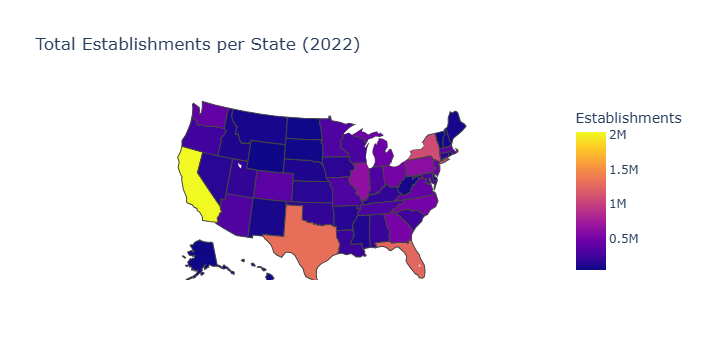

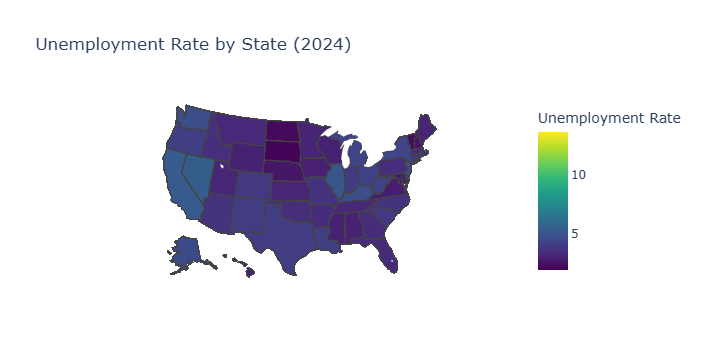

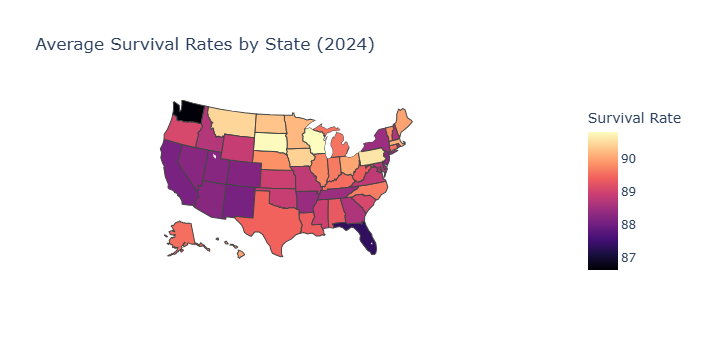

Welcome to our project, where we we will walk through our process of creating a machine learning model, which can generate predictions regarding the survival rate of a small business depending on its location and industry, while under specific economic conditions like the unemployment rate, which are depicted in the above visualizations.

Our model required a robust data collection infrastructure, followed by hyperspecific tuning parameters for the machine learning process, and then was packaged into a Flask application for a level of user interactivity.

We created this project to assist in the business development process for entrepreneurs -- an industrious person may want to start their passion project in transportation, but maybe right now is not the best time for maximum survival, perhaps when unemployment is a bit lower. Or maybe the location isn't the best, and other regions would be better fit for their startup. 

This tool would also be beneficial to those in analyst roles, who can evaluate the viability of new businesses before having to make a decision on investing or contributing to the new company's mission. 

The repository of all our files can be found here: [(https://github.com/SebastianSeljak/PIC16B_Econ)]

## Part One: Data Collection and Cleaning

To begin with, we need a source of robust, and detailed data of our predictor variables to train our model off of. The Bureau of Labor Statistics stores valuable time series data through their Public Data API, and we would use their information to base our project around. 

After combing through the API, we determined the best template of time series to be looking for. BLS had txt files of business survival information based around the state that the business was in, and another format that was centered on the industry the business serves.

The contents of this section can be seen more thoroughly in *dataset.ipynb* and *model.ipynb*

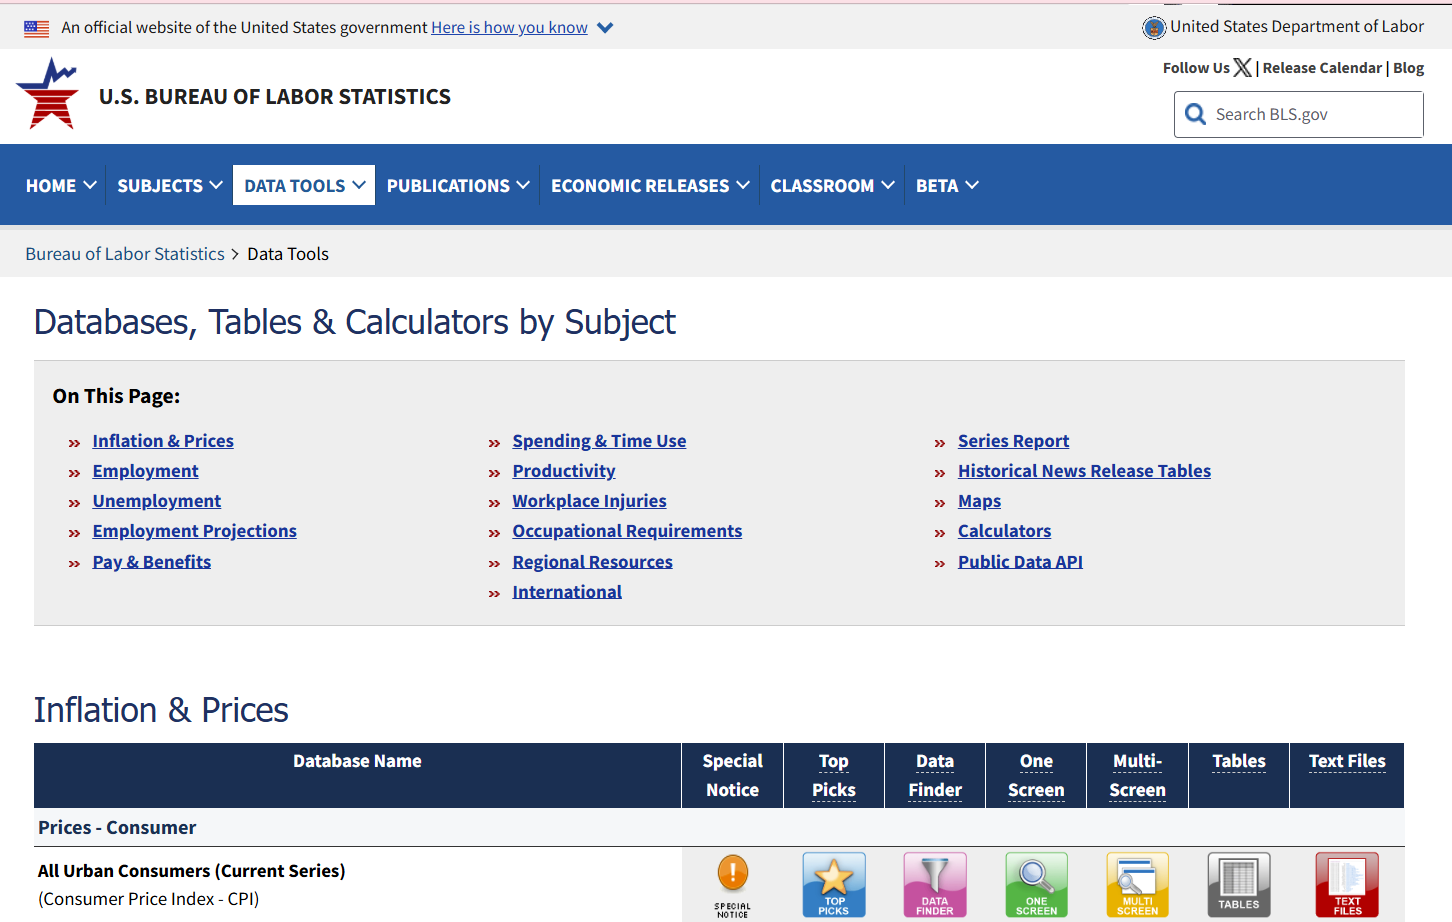

The process of our data collection is as follows, we downloaded all of the necessary files from the website. By iterating through a dictionary we built using the state and industry keys for each dataset, which would then be input into a base URL, we downloaded all of the relevant tables. In total, there were 50 state datasets, and 21 industry datasets, each of which with survival data going back to 1994. With our raw data now sorted, we now had to clean it up, as well as address a key issue. 

The cleaning process was relatively standard. After loading our data into a SQL file, we accessed each dataframe individually and created tables that focused on unemployment, state business survival, industry-specific survival rates, and the total number of establishments per year. Now, the contents of each database had to be cleaned. Datatypes had to be uniform, commas had to be removed from our numerical data, 